## Image Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import zipfile
import cv2

Setting up file locations

In [ ]:
zip_ref = zipfile.ZipFile('/storage/vocal_chords_and_rings_data/export_new.zip', 'r')
zip_ref.extractall('/storage/vocal_chords_and_rings_data/')
zip_ref.close()

In [3]:
path = Path('/storage')
path.ls()
path_lbl = path/'vocal_chords_and_rings_data/data/labels'
path_img = path/'vocal_chords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

## Data Manipulation
Converting all images and labels to .PNG files

In [12]:
! mkdir -p /storage/vocal_chords_and_rings_data/data/images
! mkdir -p /storage/vocal_chords_and_rings_data/data/labels

! mv -v /storage/vocal_chords_and_rings_data/export_new/validation/labels/* /storage/vocal_chords_and_rings_data/data/labels
! mv -v /storage/vocal_chords_and_rings_data/export_new/train/labels/* /storage/vocal_chords_and_rings_data/data/labels
! mv -v /storage/vocal_chords_and_rings_data/export_new/test/labels/* /storage/vocal_chords_and_rings_data/data/labels

! mv -v /storage/vocal_chords_and_rings_data/export_new/validation/images/* /storage/vocal_chords_and_rings_data/data/images
! mv -v /storage/vocal_chords_and_rings_data/export_new/train/images/* /storage/vocal_chords_and_rings_data/data/images
! mv -v /storage/vocal_chords_and_rings_data/export_new/test/images/* /storage/vocal_chords_and_rings_data/data/images

mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/validation/labels/*': No such file or directory
mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/train/labels/*': No such file or directory
mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/test/labels/*': No such file or directory
mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/validation/images/*': No such file or directory
mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/train/images/*': No such file or directory
mv: cannot stat '/storage/vocal_chords_and_rings_data/export_new/test/images/*': No such file or directory


In [13]:
#Convert all images to .png
from PIL import Image

for cvt_img in get_image_files(path_img):
    im = Image.open(cvt_img)
    print(str(cvt_img))
    im.save('{}.png'.format(str(cvt_img).split('.')[0]))

/storage/vocal_chords_and_rings_data/data/images/472d6b31-0000000.png
/storage/vocal_chords_and_rings_data/data/images/eed4e11f-0000000.png
/storage/vocal_chords_and_rings_data/data/images/7b7e2308-0000000.png
/storage/vocal_chords_and_rings_data/data/images/fc622ea3-0000000.png
/storage/vocal_chords_and_rings_data/data/images/c50b130d-0000000.png
/storage/vocal_chords_and_rings_data/data/images/28b50665-0000000.png
/storage/vocal_chords_and_rings_data/data/images/da1ba906-0000000.png
/storage/vocal_chords_and_rings_data/data/images/1753e9b9-0000000.png
/storage/vocal_chords_and_rings_data/data/images/bc9cd224-0000000.png
/storage/vocal_chords_and_rings_data/data/images/6d8c2704-0000000.png
/storage/vocal_chords_and_rings_data/data/images/01133d22-0000000.png
/storage/vocal_chords_and_rings_data/data/images/d742114c-0000000.png
/storage/vocal_chords_and_rings_data/data/images/6c11fbb6-0000000.png
/storage/vocal_chords_and_rings_data/data/images/a4e8953d-0000000.png
/storage/vocal_chord

In [14]:
#Remove files with old extensions (*.jpeg, *.gif)
import os

for cvt_img in get_image_files(path_img):
    if str(cvt_img).split('.')[1] == 'gif':
        os.remove('{}.gif'.format(str(cvt_img).split('.')[0]))
    if str(cvt_img).split('.')[1] == 'jpeg':
        os.remove('{}.jpeg'.format(str(cvt_img).split('.')[0]))

Splitting dataset into a Training and a Validation set:

In [10]:
#Randomly create the valid and train .txt files
import random
percent_train = 0.85
complete_list = []
complete_list = [str(i).split('/')[-1] for i in get_image_files(path_img)]
random.shuffle(complete_list)

train_list = complete_list[0:int(len(complete_list)*percent_train)]
valid_list = complete_list[int(len(complete_list)*percent_train):]

with open('/storage/vocal_chords_and_rings_data/train.txt', 'w') as f:
    for img_name in train_list:
        f.write("%s\n" % str(img_name))
with open('/storage/vocal_chords_and_rings_data/valid.txt', 'w') as f:
    for img_name in valid_list:
        f.write("%s\n" % str(img_name))

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/vocal_chords_and_rings_data/data/images/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/images/eed4e11f-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/images/07496dbb-0000000.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/vocal_chords_and_rings_data/data/labels/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/labels/eed4e11f-0000000.png'),
 PosixPath('/storage/vocal_chords_and_rings_data/data/labels/07496dbb-0000000.png')]

Let's look at our data

PosixPath('/storage/vocal_chords_and_rings_data/data/images/1753e9b9-0000000.png')

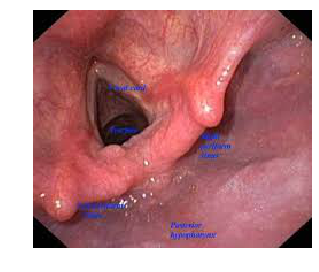

In [8]:
img_f = fnames[8]
img = open_image(img_f)
img.show(figsize=(5,5))
img_f

Make function that returns the label corresponding to a given image (i.e. the ground truth)

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

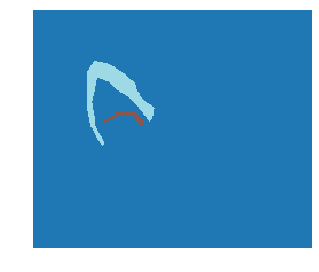

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
np_mask = np.array(mask.data)
src_size, mask.data

(array([207, 243]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
np.unique(np_mask)

array([0, 1, 2])

In [13]:
np_mask
# np_mask[int(/3):int(len(np_mask)/2)]

array([[[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]]])

In [14]:
codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str); codes

array(['everything_else', 'vocal_cord', 'trachea_ring', 'bifurcation'], dtype='<U15')

Let's convert our labels to B&W, with values between 0 and number of classes:

In [15]:
import cv2
for cvt_img in get_image_files(path_lbl):
    i = cv2.imread(str(cvt_img))
    i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    print(i.shape)
    for col in range(i.shape[1]):
        for row in range(i.shape[0]):
            if i[row][col] == 0:
                i[row][col] = 0
            if i[row][col] == 29:
                i[row][col] = 2
            if i[row][col] == 76:
                i[row][col] = 1
    
    cv2.imwrite(str(cvt_img), i)

(144, 256)
(201, 251)
(480, 720)
(206, 244)
(186, 270)
(137, 324)
(176, 286)
(293, 400)


KeyboardInterrupt: 

Let's look at our new labels

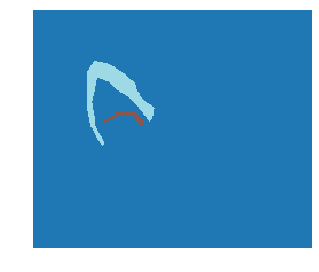

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [17]:
src_size = np.array(mask.shape[1:])
np_mask = np.array(mask.data)
src_size,mask.data

(array([207, 243]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [18]:
np.unique(np_mask)

array([0, 1, 2])

## Datasets

In [19]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 12307MB of GPU RAM free


In [20]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (104 items)
x: SegmentationItemList
Image (3, 201, 251),Image (3, 480, 720),Image (3, 206, 244),Image (3, 186, 270),Image (3, 176, 286)
y: SegmentationLabelList
ImageSegment (1, 201, 251),ImageSegment (1, 480, 720),ImageSegment (1, 206, 244),ImageSegment (1, 186, 270),ImageSegment (1, 176, 286)
Path: /storage/vocal_chords_and_rings_data/data/images;

Valid: LabelList (19 items)
x: SegmentationItemList
Image (3, 144, 256),Image (3, 137, 324),Image (3, 194, 259),Image (3, 480, 720),Image (3, 203, 300)
y: SegmentationLabelList
ImageSegment (1, 144, 256),ImageSegment (1, 137, 324),ImageSegment (1, 194, 259),ImageSegment (1, 480, 720),ImageSegment (1, 203, 300)
Path: /storage/vocal_chords_and_rings_data/data/images;

Test: None

In [21]:
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

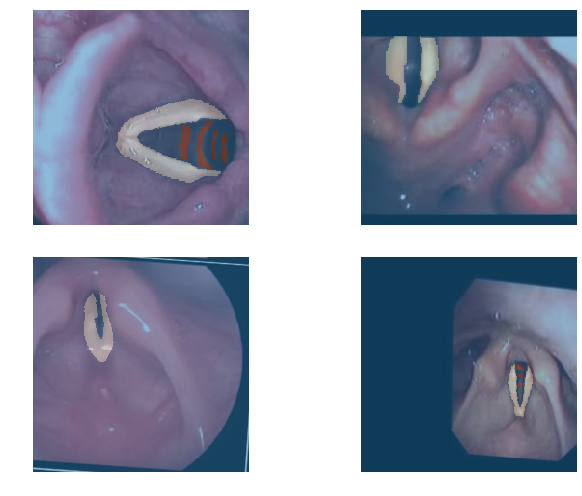

In [22]:
data.show_batch(2, figsize=(10,7))

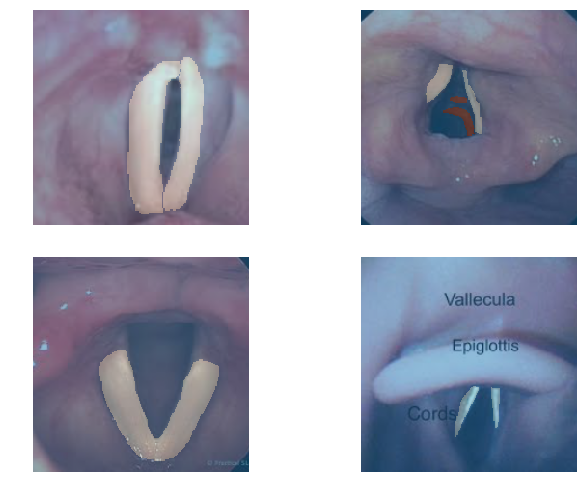

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Make a custom accuracy metric

In [23]:
def acc_trachea(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [24]:
metrics=acc_trachea
# metrics=accuracy

In [25]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


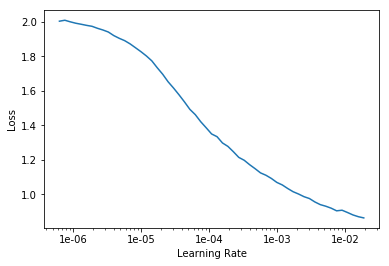

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=1e-4

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_trachea,time
0,1.605987,1.174046,0.332992,00:05
1,1.154315,0.678153,0.840148,00:04
2,0.916276,0.543602,0.864740,00:04
3,0.748321,0.402632,0.871670,00:04
4,0.626358,0.413396,0.873533,00:04
5,0.560100,0.370933,0.872821,00:04
6,0.489739,0.293309,0.899266,00:04
7,0.447532,0.357820,0.893907,00:04
8,0.402120,0.278505,0.901757,00:04
9,0.361819,0.258081,0.912385,00:04


In [33]:
learn.save('stage-1')

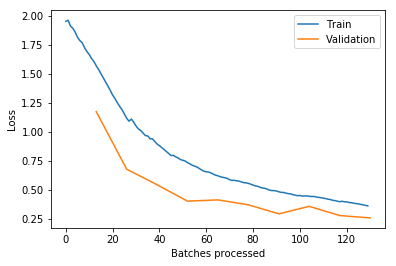

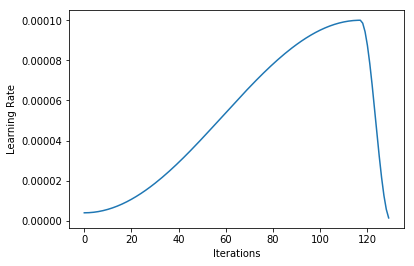

In [30]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [26]:
learn.load('stage-1-new-data');

In [27]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

AttributeError: 'Learner' object has no attribute 'recorder'

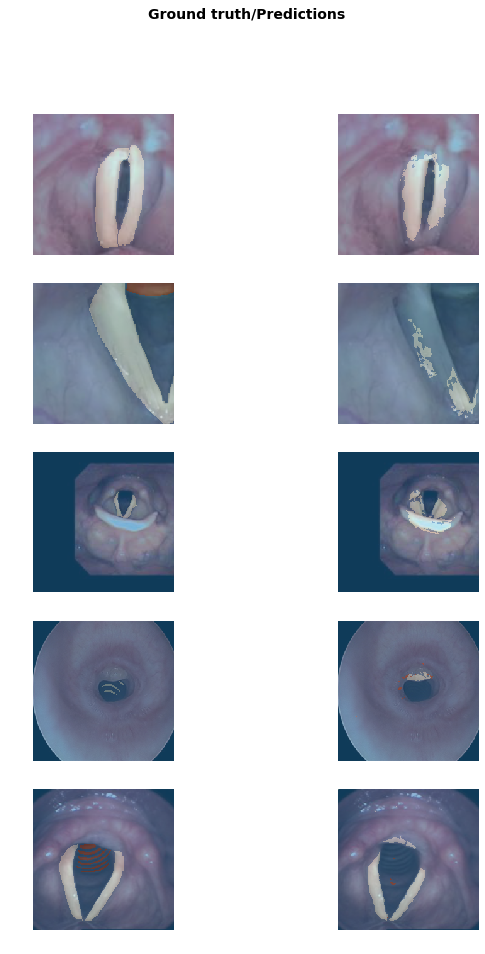

In [31]:
learn.show_results(rows=5, figsize=(10,15))

In [32]:
learn.unfreeze()

In [33]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.218472,0.248464,0.912323,00:05
1,0.209953,0.244482,0.912176,00:04
2,0.206590,0.234804,0.917887,00:04
3,0.206788,0.230715,0.919140,00:04
4,0.201871,0.227230,0.924839,00:04
5,0.197076,0.222375,0.923989,00:04
6,0.197752,0.218177,0.923720,00:04
7,0.195243,0.218478,0.923232,00:04
8,0.189242,0.201381,0.928319,00:04
9,0.192485,0.247852,0.905031,00:04


In [58]:
learn.save('stage-2-interim', return_path=True)

PosixPath('/storage/vocal_chords_and_rings_data/data/images/models/stage-2-interim.pth')

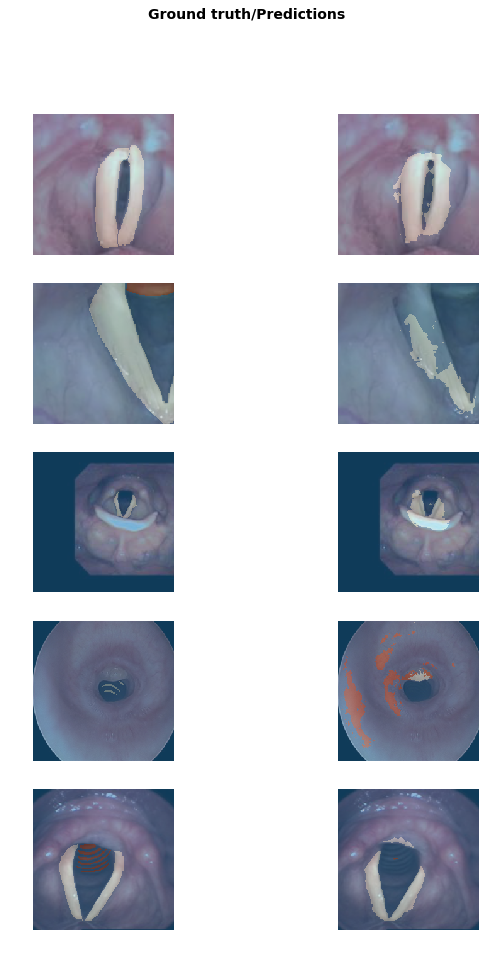

In [39]:
learn.show_results(rows=5, figsize=(10,15))

## Go big

In [40]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 14351MB of GPU RAM free


In [41]:
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [63]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [64]:
learn.load('stage-2-interim');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


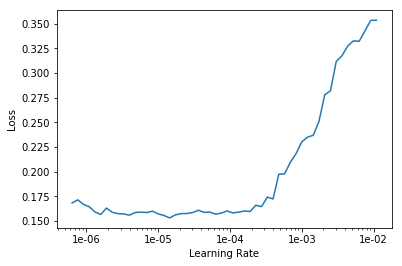

In [42]:
lr_find(learn)
learn.recorder.plot()

In [43]:
lr=1e-6

In [44]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.149341,0.209433,0.924362,00:04
1,0.156294,0.214395,0.923507,00:04
2,0.154127,0.207772,0.924920,00:04
3,0.155084,0.211570,0.924529,00:04
4,0.159399,0.210799,0.924462,00:04
5,0.159882,0.209249,0.923996,00:04
6,0.159744,0.205674,0.925738,00:04
7,0.157949,0.203329,0.926790,00:04
8,0.157962,0.204037,0.926739,00:04
9,0.157543,0.202216,0.927194,00:04


In [63]:
learn.save('stage-1-big')

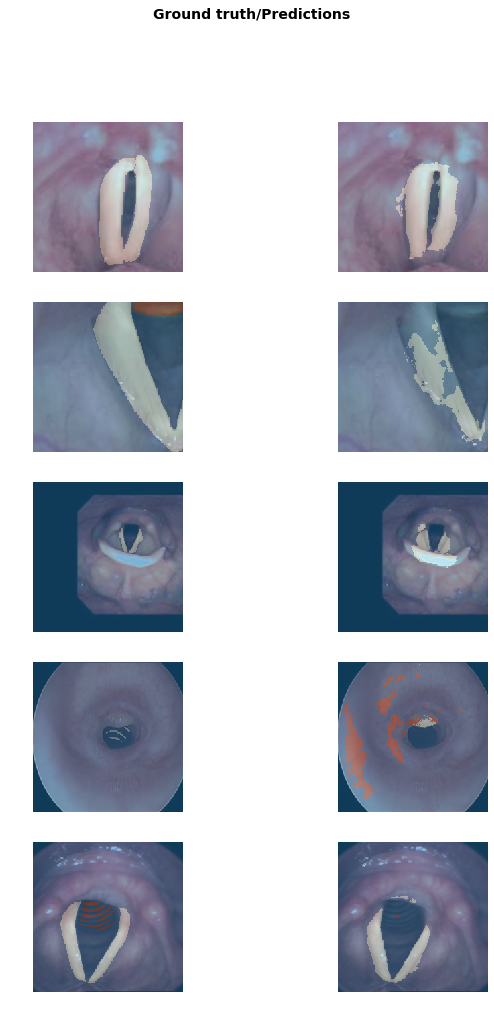

In [45]:
learn.show_results(rows=5, figsize=(10,16))

In [49]:
learn.load('stage-1-big-good');

In [46]:
learn.unfreeze()

In [47]:
lrs = slice(1e-6,lr/10)

In [48]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.148437,0.203660,0.926320,00:04
1,0.150559,0.200344,0.927352,00:04
2,0.153250,0.206135,0.925562,00:04
3,0.151323,0.208185,0.924312,00:04
4,0.150393,0.206238,0.924735,00:04
5,0.148535,0.204451,0.926183,00:05
6,0.152160,0.204464,0.927540,00:04
7,0.154043,0.201913,0.926872,00:04
8,0.153811,0.203525,0.926392,00:04
9,0.154213,0.204201,0.926044,00:04


In [51]:
learn.save('stage-2-big-0606', return_path=True)

PosixPath('/storage/vocal_chords_and_rings_data/data/images/models/stage-2-big-0606.pth')

In [34]:
learn.load('stage-2-big');

## Final Results

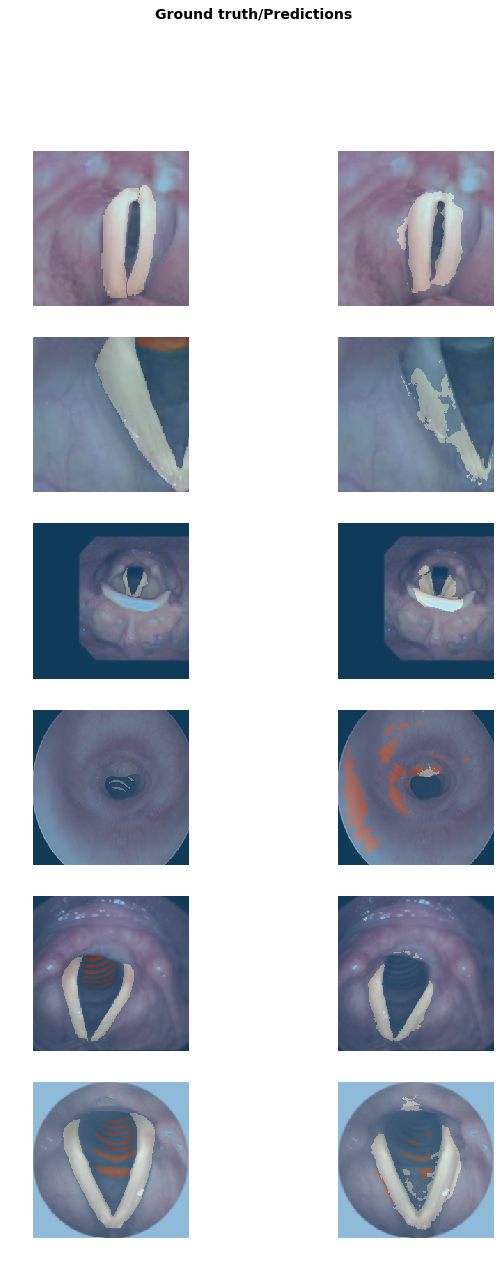

In [49]:
learn.show_results(rows=6, figsize=(10,20))

In [39]:
learn.load('stage-2-big');
model = learn.model

In [50]:
type(model);
torch.save(model,"/storage/vocal_chords_and_rings_data/data/images/models/model_0606_final")

NameError: name 'model' is not defined

In [43]:
the_model = torch.load("/storage/vocal_chords_and_rings_data/data/images/models/torch_model_v1")

In [46]:
type(the_model);

In [48]:
# the_model.load_state_dict(the_model)

dummy_input = Variable(torch.randn(1, 1, 224,224))
torch.onnx.export(trained_model, dummy_input, "/storage/vocal_chords_and_rings_data/data/images/models/stage-2-big.onnx")

AttributeError: 'Learner' object has no attribute 'state_dict'

In [36]:
from torch.autograd import Variable

# Load the trained model from file
# trained_model = Net()
trained_model.load_state_dict(torch.load('output/mnist.pth'))
# trained_model = learn
# Export the trained model to ONNX
dummy_input = Variable(torch.randn(1, 1, 224,224)) # one black and white 28 x 28 picture will be the input to the model
torch.onnx.export(trained_model, dummy_input, "/storage/vocal_chords_and_rings_data/data/images/models/stage-2-big.onnx")

AttributeError: 'Learner' object has no attribute 'load_state_dict'

Prediction time: 1.6313183307647705


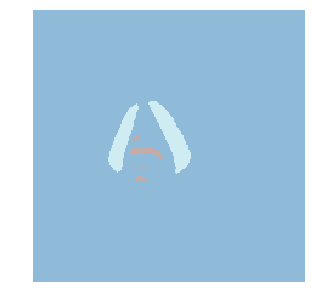

In [32]:
import time

img = open_image('/storage/vocal_chords_and_rings_data/data/images/bc9cd224-0000000.png')
start = time.time()
prediction = learn.predict(img)
end = time.time()
print("Prediction time: {}".format(end - start))
prediction[0].show(figsize=(5,5))

# ??learn.predict

In [33]:
learn.load('stage-2-big') # or whatever your saved model is
example = torch.rand(2, 3, 224, 224) # dummy batch size, n_chanels, w, h
learn.model.training = False # disable dropout
learn.model = learn.model.cpu() # move to CPU

In [34]:
#traced_script_module = torch.jit.trace(learn.model, example)
# traced_script_module.save("model.pt")

## Closing notes:

Architecture: U-Net with (ResNet34 for encoder)

Training Dataset Size: 88 imgs

Validation Dataset Size: 16 imgs

Prediction time: ~3ms

Accuracy: 97.45%